# Latent Interview Protocol Engineer (LIPE) Example
**Zac Lim, 2026-01-03**

In this notebook, I'll use LIPE to recover the latent interview protocol for the toy interviews we generated. If it works, we should recover the same protocol we used to generate the interviews.

Here's a high-level summary. First, we [fit the LIPE model](#fitting) in a single line of code. Then, we [look through the questions it identified](#inspecting) to see if certain topics need to be merged, split, etc. This is done by looking at examples of interviewer lines classified under that question. We then [looked at the lines the initial model failed to classify and classified them](#refitting), some automatically some by hand. Finally, [we arrive at a latent interview protocol we're happy with](#final), which we then use to [export information](#exporting) as requested by other researchers on the team and take a stab at [exploring the responses to these questions](#eda).

I recommend looking though a few examples for each of these steps and them skipping over the rest to at least get a sense of the workflow.

## Preparation <a id="preparation"></a>
Start with loading LIPE and the data.

In [1]:
from LIPE import LIPE
from interactive_topic_model.components import e5_base_embedder
import pandas as pd


In [2]:
lines = pd.read_csv('toy_interviews.csv')
lines

interview_id  line_id  speaker_id  \
0                0        0           0   
1                0        1           1   
2                0        2           0   
3                0        3           1   
4                0        4           0   
...            ...      ...         ...   
1609            99       10           0   
1610            99       11           1   
1611            99       12           0   
1612            99       13           1   
1613            99       14           0   

                                                   text  
0                         What year are you in college?  
1                    I just started, so I'm a freshman.  
2                 Do you know what you'd like to study?  
3      I'm exploring a few different options right now.  
4                     What options are you considering?  
...                                                 ...  
1609                             Why further education?  
1610     I love my field and want to go deeper into it.  
1611  Is there anything else you'd like to share abo...  
1612                        No, I think that covers it.  
1613  Thanks for talking with me about your college ...  

[1614 rows x 4 columns]

## Fitting the LIPE model <a id="fitting"></a>

The LIPE package is very easy to use--it can be done in _a single line_! There are many hyperparameters you can adjust--see the documentation for the full list--but they have default values that work in most cases. The main one I recommend you consider setting is `min_cluster_size`, which defaults to 1/5 of the number of interviews--that is, we assume that protocol questions occur in at least a quarter of the interviews. This assumption is just for the initial fitting of the model and you can always create smaller questions later (as I do in this example). However, if you have an idea from the get go that questions that occur more than, say, 5 times are potential protocol questions, then you can set `min_cluster_size=5`.

Note that the first time you are using an embedding model, python will have to download it so it may take a while, but subsequent runs should be much faster.

In [3]:
l = LIPE(lines, embedder=e5_base_embedder(), min_cluster_size=25)
l


<LIPE
  Questions: 18
  Lines: 857
  Classified: 604 (70.5%)
  Outliers: 253 (29.5%)
  Interviews: 100
>

## Exploring the initial fit <a id="init_exploration"></a>

The key difference between LIPE and most other topic model packages is that LIPE makes it easy for you to investigate and manipulate the topics (in this case, questions) initially fit; we don't assume that the semantic features salient in the language model are relevant to the research. In this section, I investigate the top words and some examples for each topic. With this information, I proceed to assign my own labels to the topics. If I think some topics really should be the same thing, I give them the same label so we can easily merge them later. And if I think they're too heterogenous, I use parentheses to indicate the different things I see so I can split later.

In [4]:
l.get_question_info()

topic_id                                              label  count  \
0         -1                                           OUTLIERS    253   
1          0  0_thank_thank sharing_sharing_sharing experiences     27   
2          1          1_point_point going_going college_college     33   
3          2   2_thoughts college_thoughts_final_final thoughts     29   
4          3                      3_school_decide_decide school     26   
5          4              4_did_did choose_choose attend_choose     28   
6          5     5_talked_talked like_haven talked_like mention     28   
7          6                  6_want_education_grad_grad school     35   
8          7         7_think people_think_people_people college     30   
9          8         8_senior_sophomore_sophomore junior_junior     36   
10         9    9_think purpose_purpose college_purpose_college     37   
11        10      10_really_thank really_really helpful_helpful     29   
12        11                                        11_graduate     26   
13        12           12_year school_year_current_current year     31   
14        13                   13_major_looking_know_like study     35   
15        14               14_major_feel major_feel_major point     33   
16        15             15_year college_year_college_currently     45   
17        16       16_doing college_doing_plans_post graduation     29   
18        17       17_location_makes_makes hard_location worked     67   

                                            top_terms  
0                                                      
1   thank, thank sharing, sharing, sharing experie...  
2   point, point going, going college, college, going  
3   thoughts college, thoughts, final, final thoug...  
4                       school, decide, decide school  
5   did, did choose, choose attend, choose, attend...  
6   talked, talked like, haven talked, like mentio...  
7   want, education, grad, grad school, want grad,...  
8   think people, think, people, people college, c...  
9   major, did, did decide, decide major, decide, ...  
10  think purpose, purpose college, purpose, colle...  
11  really, thank really, really helpful, helpful,...  
12                                           graduate  
13   year school, year, current, current year, school  
14  major, know, like study, know like, thinking m...  
15  major, feel major, feel, major point, point, r...  
16  year college, year, college, currently, colleg...  
17                      doing college, doing, college  
18  location, makes, makes hard, location worked, ...

In [5]:
l.get_examples()

{(0,
  '0_thank_thank sharing_sharing_sharing experiences'): ['Thank you so much for sharing your experiences with me.', 'Thank you so much for sharing your experiences with me.', 'Thank you so much for sharing your experiences with me.', 'Thank you so much for sharing your experiences with me.', 'Thank you so much for sharing your experiences with me.'],
 (1,
  '1_point_point going_going college_college'): ["What's the point of going to college?", "What's the point of going to college?", "What's the point of going to college?", "What's the point of going to college?", "What's the point of going to college?"],
 (2,
  '2_thoughts college_thoughts_final_final thoughts'): ['Any final thoughts on college?', 'Any final thoughts on college?', 'Any final thoughts on college?', 'Any final thoughts on college?', 'Any final thoughts on college?'],
 (3, '3_school_decide_decide school'): ['What made you decide on this school?',
  'What made you decide on this school?',
  'What made you decide on t

I like to do this work in bulk using a dictionary. As you can see, the model determined that "Any final thoughts on college?" and "Is there something we haven't talked about that you'd like to mention?" were different questions, and in some contexts that might very well be the case, but I decide that they're both "anything else" questions asked at the end of the interview. Perhaps we might want to keep them separate to find out if phrasing this question differently generates different responses, e.g., maybe the students have more to say that isn't college related so if we ask the more general question we find out something unexpected. 

Looking at question 15, I also see both questions about deciding on a major and switching majors. For me, these are different questions I want to be able to investigate separately, so I indicate in my label that there's a range of topics. We'll revisit this later.

These are just examples of the interpretive judgments that go into organizing your data. 

In [6]:
label_dict = {
    0: 'Thanks',
    1: 'Purpose of college',
    2: 'Anything else',
    3: 'Why this college',
    4: 'Why this college',
    5: 'Anything else',
    6: 'Why grad school',
    7: 'Purpose of college',
    8: 'Why (change) major',
    9: 'Purpose of college',
    10: 'Thanks',
    11: 'Post-grad plans',
    12: 'Current year',
    13: 'Major considerations',
    14: 'Thoughts on major',
    15: 'Current year',
    16: 'Post-grad plans',
    17: 'Uncertainty/location',
}

l.label_questions(label_dict)

You can also visualize these initially recovered topics as a dendrogram to get an idea of which topics are more similar. As you can see below, the topics we decided should get the same labels are in fact similar. Note we have different ways of comparing how similar the topics are. I used embeddings because I know questions can be phrased using different words (e.g., asking what year a student is in or asking them if they're a freshman, sophomore, junior, or senior has almost no words in common).

In [7]:
l.visualize_question_hierarchy(similarity="embedding")

## Making changes <a id="changes"></a>

And now we can dive into adjusting the questions. 

### Merging <a id="merge"></a>

First, I just tell LIPE to merge all the questions that have the same label--easy as that! You can also manually merge questions with `merge_questions()`.

In [8]:
l.merge_questions_by_label()

In [9]:
l.get_question_info()

topic_id                 label  count  \
0         -1              OUTLIERS    253   
1          0                Thanks     56   
2          1    Purpose of college    100   
3          2         Anything else     57   
4          3      Why this college     54   
5          6       Why grad school     35   
6          8    Why (change) major     36   
7         11       Post-grad plans     55   
8         12          Current year     76   
9         13  Major considerations     35   
10        14     Thoughts on major     33   
11        17  Uncertainty/location     67   

                                            top_terms  
0                                                      
1   thank, thank really, really, really helpful, h...  
2   college, think, going, going college, point go...  
3   thoughts college, final thoughts, final, haven...  
4   attend, attend college, did choose, choose att...  
5   want, education, grad, grad school, want grad,...  
6   major, did, did decide, decide major, decide, ...  
7             doing college, doing, graduate, college  
8   year, year college, year school, current year,...  
9   major, know, like study, know like, thinking m...  
10  major, feel major, feel, major point, point, r...  
11  location, makes, makes hard, location worked, ...

### Splitting <a id="split"></a>

I'm also going to split the questions we flagged as containing more than one topics just now. I do that by asking LIPE to split it. Note that you can ask LIPE to immediately go ahead with the split by setting `commit=True`, but I prefer to preview the proposed split first. I'm also setting `min_cluster_size` smaller here.

In [10]:
split_preview = l.questions[17].preview_split(min_topic_size=5)
split_preview

doc_id  new_topic_id  strength                                        text
4       76  preview-17-0  1.000000            Are you happy with the location?
5      112  preview-17-0  1.000000  Do you still feel good about the location?
17     293  preview-17-0  1.000000  Do you still feel good about the location?
19     323  preview-17-0  1.000000  Do you still feel good about the location?
36     762  preview-17-0  1.000000  Do you still feel good about the location?
..     ...           ...       ...                                         ...
1       36  preview-17-5  0.201563                What's making you uncertain?
39     841  preview-17-5  0.189975                What's making you uncertain?
58    1251  preview-17-5  0.128004        What's behind those second thoughts?
6      125  preview-17-5  0.126499        What's behind those second thoughts?
52    1097  preview-17-5  0.120535        What's behind those second thoughts?

[67 rows x 4 columns]

Another helpful way to preview a split is to visualize it.

In [11]:
l.questions[17].visualize_split_preview()

This looks good to me, although I may want to merge some of those again. Let's commit the split (i.e., accept and implement it) and move on.

In [12]:
new_topic_labels = {
    'preview-17-0': 'Location',
    'preview-17-1': 'Location',
    'preview-17-2': 'Major considerations',
    'preview-17-3': 'Uncertainty',
    'preview-17-4': 'Uncertainty',
    'preview-17-5': 'Uncertainty',
}

l.questions[17].commit_split(new_topic_labels, delete_parent=True)

split_preview = l.questions[8].preview_split(min_topic_size=5)
split_preview

doc_id  new_topic_id  strength                                        text
0       21  preview-8--1  0.000000                   What prompted the change?
3       72  preview-8--1  0.000000                 How did you decide on that?
14     515  preview-8--1  0.000000                  What led to that decision?
27    1065  preview-8--1  0.000000                       What changed for you?
28    1082  preview-8--1  0.000000                  What led to that decision?
31    1381  preview-8--1  0.000000                   What prompted the change?
33    1428  preview-8--1  0.000000    What made you so sure about that choice?
4       93   preview-8-0  1.000000            What made you change your major?
11     379   preview-8-0  1.000000            What made you change your major?
12     413   preview-8-0  1.000000            What made you change your major?
23     839   preview-8-0  1.000000                 What led you to your major?
30    1332   preview-8-0  1.000000            What made you change your major?
15     562   preview-8-0  0.915454               Why did you decide to switch?
18     645   preview-8-0  0.860731                 What led you to your major?
7      178   preview-8-0  0.856773                What drew you to that major?
13     462   preview-8-0  0.793923                 What led you to your major?
19     681   preview-8-0  0.764202            What made you change your major?
26     969   preview-8-0  0.687198                 What led you to your major?
6      138   preview-8-0  0.621941                 What led you to your major?
16     581   preview-8-0  0.469969                What drew you to that major?
35    1554   preview-8-0  0.273932  If you could switch, what would you study?
8      242   preview-8-1  1.000000           How did you decide on your major?
10     304   preview-8-1  1.000000           How did you decide on your major?
22     822   preview-8-1  1.000000           How did you decide on your major?
32    1396   preview-8-1  1.000000           How did you decide on your major?
34    1443   preview-8-1  1.000000           How did you decide on your major?
9      274   preview-8-1  0.969955           How did you decide on your major?
1       34   preview-8-1  0.771141           How did you decide on your major?
25     954   preview-8-1  0.744473           How did you decide on your major?
2       53   preview-8-2  1.000000            What made you choose your major?
17     628   preview-8-2  1.000000       Why did you pick that field of study?
21     775   preview-8-2  1.000000       Why did you pick that field of study?
24     922   preview-8-2  1.000000       Why did you pick that field of study?
29    1215   preview-8-2  1.000000       Why did you pick that field of study?
5      108   preview-8-2  0.870574       Why did you pick that field of study?
20     743   preview-8-2  0.769421            What made you choose your major?

This is more subtle. `preview-8-1` and `preview-8-2` make sense and are both about major decision, but `preview-8--1` and `preview-8-0` still include a mix of 'why did you pick your major' and 'why did you switch', which I consider to be different questions. For now, I'll still split it and we'll do more with the leftover topics later. 

In [13]:
new_topic_labels = {
    'preview-8--1': 'Why (change) major',
    'preview-8-0': 'Why (change) major',
    'preview-8-1': 'Why choose major',
    'preview-8-2': 'Why choose major',
}

l.questions[8].commit_split(new_topic_labels, delete_parent=True)

In [14]:
l.merge_questions_by_label()
l.get_question_info()

topic_id                 label  count  \
0         -1              OUTLIERS    253   
1          0                Thanks     56   
2          1    Purpose of college    100   
3          2         Anything else     57   
4          3      Why this college     54   
5          6       Why grad school     35   
6         11       Post-grad plans     55   
7         12          Current year     76   
8         13  Major considerations     44   
9         14     Thoughts on major     33   
10        18              Location     19   
11        21           Uncertainty     39   
12        24    Why (change) major     21   
13        26      Why choose major     15   

                                            top_terms  
0                                                      
1   thank, thank really, really, really helpful, h...  
2   college, think, going, going college, point go...  
3   thoughts college, final thoughts, final, haven...  
4   attend, attend college, did choose, choose att...  
5   want, education, grad, grad school, want grad,...  
6             doing college, doing, graduate, college  
7   year, year college, year school, current year,...  
8   thinking, know like, know, like study, majorin...  
9   major, feel major, feel, major point, point, r...  
10  location, worked, location worked, happy locat...  
11  makes, makes hard, hard decide, hard, uncertai...  
12  major, led, change, led major, change major, p...  
13  did, decide major, did decide, major, pick, pi...

### Semantic searching <a id="search"></a>

Perhaps a more effective way to go about this is to search for questions, since we've already identified that there are questions about deciding on and switching majors. For this, LIPE can search through all the texts to tell you which ones are the most similar. The best part is, we can ask it to compare the text using different embedding models! Not specifying a new model let's it do a quick comparison with existing embeddings. Let's try both!

In [15]:
major_switch_sim_df = l.similarity_search("Why did you switch majors?")

We have many repeat lines in this toy dataset so let's remove those. But honestly, this isn't bad at all! Everything with a similarity above .933 seems to be what we want.

In [16]:
major_switch_sim_df.groupby('text').first().sort_values('similarity', ascending=False).head(20)

doc_id  similarity
text                                                                  
What made you change your major?                       681    0.956475
Why did you decide to switch?                          562    0.933374
What led you to your major?                            839    0.931226
What made you choose your major?                        53    0.930857
What drew you to that major?                           178    0.927454
Why did you pick that field of study?                  628    0.913737
How did you decide on your major?                      274    0.912731
Why did you choose to attend this college?             713    0.890604
If you could switch, what would you study?            1554    0.890174
In retrospect, how do you feel about your major?       711    0.878971
What's your take on your major now?                    289    0.874042
What drew you to this college?                         760    0.872132
Looking back, would you choose the same major a...    1552    0.871043
What are you thinking of majoring in?                  394    0.870888
What made you decide on this school?                   278    0.868118
How did you choose this particular college?           1005    0.865441
How's your major working out for you?                  257    0.863691
Why do you want to go to grad school?                 1357    0.863543
How do you feel about your major at this point?        560    0.863493
Do you have any regrets about your major choice?      1283    0.861759

Let's try using a different embedding model from [`SentenceTransformers`](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html) or [HuggingFace](https://huggingface.co/models). If you haven't downloaded the model before, this might take some time.

As you can see, this model has a slightly different ordering, but moral of the story here is that embedding spaces encode different things differently, and there's no correct embedder. Some may be better for your purposes than others, but at the end of the day we still need to make judgments and the models are just here to make that work easier. I'll use the previous model and just manually exclude the change question.

In [17]:
major_switch_sim_alt_df = l.similarity_search("Why did you switch majors?", embedding_model='multi-qa-mpnet-base-dot-v1')
major_switch_sim_alt_df.groupby('text').first().sort_values('similarity', ascending=False).head(20)

doc_id  similarity
text                                                                  
What made you change your major?                        93    0.922245
What made you choose your major?                       743    0.865385
Why did you decide to switch?                          562    0.853824
How did you decide on your major?                     1396    0.845962
What led you to your major?                            462    0.831519
What drew you to that major?                           581    0.824208
Why did you pick that field of study?                 1215    0.798756
Have you picked a major yet?                          1298    0.770685
In retrospect, how do you feel about your major?       347    0.750475
Do you have any regrets about your major choice?      1048    0.747522
What's your take on your major now?                    890    0.727544
Have you thought about what you want to major in?      596    0.720785
Looking back, would you choose the same major a...    1409    0.709607
If you could do it over, would you pick the sam...    1460    0.705620
What are you thinking of majoring in?                 1475    0.704999
Why did you choose to attend this college?            1302    0.703489
If you could switch, what would you study?            1554    0.698843
How do you feel about your major at this point?       1364    0.687968
How's your major working out for you?                   91    0.674675
How did you choose this particular college?            336    0.671190

### Creating new questions <a id="create"></a>

Using these dataframes, we can create a new question and pass along the `doc_id`s we want to move to the new question:

In [18]:
major_switch_ids = major_switch_sim_df[major_switch_sim_df['similarity']>.933].doc_id.to_list()

l.create_question(doc_ids=major_switch_ids, label="Why switch majors", validate=True)

28

So now if we look at our list of questions, we see that question 8 has fewer topics because we moved them to the new question.

In [19]:
l.get_question_info()

topic_id                 label  count  \
0         -1              OUTLIERS    253   
1          0                Thanks     56   
2          1    Purpose of college    100   
3          2         Anything else     57   
4          3      Why this college     54   
5          6       Why grad school     35   
6         11       Post-grad plans     55   
7         12          Current year     76   
8         13  Major considerations     44   
9         14     Thoughts on major     33   
10        18              Location     19   
11        21           Uncertainty     39   
12        24    Why (change) major     15   
13        26      Why choose major     15   
14        28     Why switch majors      6   

                                            top_terms  
0                                                      
1   thank, thank really, really, really helpful, h...  
2   college, think, going, going college, point go...  
3   thoughts college, final thoughts, final, haven...  
4   attend, attend college, did choose, choose att...  
5   want, education, grad, grad school, want grad,...  
6             doing college, doing, graduate, college  
7   year, year college, year school, current year,...  
8   thinking, know like, know, like study, majorin...  
9   major, feel major, feel, major point, point, r...  
10  location, worked, location worked, happy locat...  
11  makes, makes hard, hard decide, hard, uncertai...  
12  led, led major, major, led decision, prompted ...  
13  did, decide major, did decide, major, pick, pi...  
14  change major, change, major, switch, did decid...

Looking inside 24, we still see a mix of topics. I'll first extract out the 'Why choose major' questions.

In [20]:
set(l.questions[24].get_examples(n=20))

{'How did you decide on that?',
 'If you could switch, what would you study?',
 'What changed for you?',
 'What drew you to that major?',
 'What led to that decision?',
 'What led you to your major?',
 'What made you so sure about that choice?',
 'What prompted the change?'}

In [21]:
major_choice_sim_df = l.similarity_search("Why that major?")
major_choice_sim_df.groupby('text').first().sort_values('similarity', ascending=False).head(5)

doc_id  similarity
text                                                     
What drew you to that major?              581    0.906562
What led you to your major?               839    0.884244
What made you choose your major?           53    0.879456
What made you change your major?           93    0.872288
What are you thinking of majoring in?    1110    0.869889

In [22]:
major_choice_ids = major_choice_sim_df[major_choice_sim_df['similarity']>.879].doc_id.to_list()
l.manual_reassign({id: 26 for id in major_choice_ids})

{'reassigned': 9}

As for the rest, I'll shelve them as outliers since we're going to refit those soon.

In [23]:
l.questions[24].junk()

In [24]:
l.get_question_info()

topic_id                 label  count  \
0         -1              OUTLIERS    261   
1          0                Thanks     56   
2          1    Purpose of college    100   
3          2         Anything else     57   
4          3      Why this college     54   
5          6       Why grad school     35   
6         11       Post-grad plans     55   
7         12          Current year     76   
8         13  Major considerations     44   
9         14     Thoughts on major     33   
10        18              Location     19   
11        21           Uncertainty     39   
12        26      Why choose major     22   
13        28     Why switch majors      6   

                                            top_terms  
0                                                      
1   thank, thank really, really, really helpful, h...  
2   college, think, going, going college, point go...  
3   thoughts college, final thoughts, final, haven...  
4   attend, attend college, did choose, choose att...  
5   want, education, grad, grad school, want grad,...  
6             doing college, doing, graduate, college  
7   year, year college, year school, current year,...  
8   thinking, know like, know, like study, majorin...  
9   major, feel major, feel, major point, point, r...  
10  location, worked, location worked, happy locat...  
11  makes, makes hard, hard decide, hard, uncertai...  
12  major, did, decide major, did decide, pick, pi...  
13  change major, change, major, switch, did decid...

### Outliers <a id="outliers"></a>

Now, we can deal with the 261 outliers. Based on the way I generated this dataset, I don't expect there to be any real outliers, but in an actual interview, we would expect one-off followup questions that should not be considered protocol questions but rather incidental ones. As such, the task is to make sure that there are no other protocol questions hidden among the outliers. 

#### Reassigning to existing topics

Once again, we can use a single line to ask LIPE to first check if any of the outliers might actually belong in one of the existing questions. Looking at a histogram of scores for the refitting, it seems are are quite a few lines that are already very close to existing questions.

<Axes: >

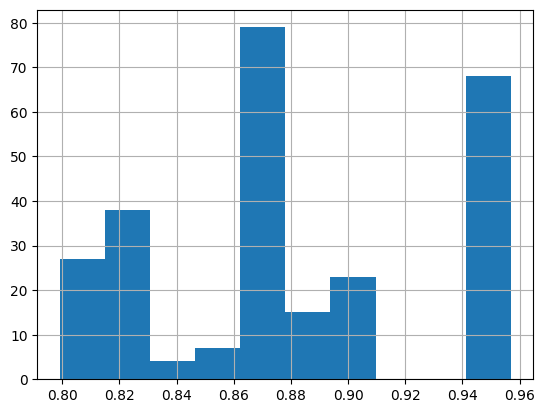

In [25]:
outliers_df = l.refit_outliers()
outliers_df.score.hist()

The `refit_outliers` function gives us a nice dataframe showing what the suggested labels are. A quick scan tells me anything above a score of .9 has reassignments I approve of.

In [26]:
outliers_df.sort_values('score', ascending=False).drop_duplicates(subset="text", keep="first")

doc_id  current_topic  suggested_topic       suggested_label     score  \
238    1507             -1                3      Why this college  0.956900   
6        57             -1                3      Why this college  0.953479   
231    1466             -1               11       Post-grad plans  0.943808   
256    1592             -1               13  Major considerations  0.896703   
131     805             -1               13  Major considerations  0.883875   
10       72             -1               26      Why choose major  0.882146   
247    1554             -1               28     Why switch majors  0.881853   
226    1428             -1               26      Why choose major  0.881830   
246    1552             -1               13  Major considerations  0.881573   
62      459             -1                0                Thanks  0.877125   
205    1283             -1               26      Why choose major  0.871055   
108     689             -1                2         Anything else  0.868468   
37      287             -1               12          Current year  0.867927   
167    1065             -1               28     Why switch majors  0.867776   
183    1168             -1               13  Major considerations  0.867186   
137     858             -1               21           Uncertainty  0.860621   
241    1526             -1               14     Thoughts on major  0.859282   
145     911             -1               21           Uncertainty  0.856649   
74      515             -1               26      Why choose major  0.837826   
0        21             -1               28     Why switch majors  0.837438   
98      625             -1                2         Anything else  0.820019   
224    1415             -1               11       Post-grad plans  0.817666   
248    1560             -1               26      Why choose major  0.816558   
132     811             -1                1    Purpose of college  0.814273   
95      619             -1                1    Purpose of college  0.800049   
93      606             -1               13  Major considerations  0.799195   

                                                  text  reassigned  
238                     What drew you to this college?       False  
6          How did you choose this particular college?       False  
231              What are your plans after graduation?       False  
256      Have you thought about post-graduation plans?       False  
131  If you could do it over, would you pick the sa...       False  
10                         How did you decide on that?       False  
247         If you could switch, what would you study?       False  
226           What made you so sure about that choice?       False  
246  Looking back, would you choose the same major ...       False  
62         I really appreciate your time and insights.       False  
205   Do you have any regrets about your major choice?       False  
108  Is there anything else you'd like to share abo...       False  
37   Are you a freshman, sophomore, junior, or senior?       False  
167                              What changed for you?       False  
183          Are you satisfied with your major choice?       False  
137            Why are you confident in that decision?       False  
241                   What's your current perspective?       False  
145                     How are you thinking about it?       False  
74                          What led to that decision?       False  
0                            What prompted the change?       False  
98   Thanks for talking with me about your college ...       False  
224             How does that relate to getting a job?       False  
248                      What about the career aspect?       False  
132  Do you think that's separate from career prepa...       False  
95           Is that distinct from professional goals?       False  
93                      Anything else you want to add?       False

So let's go ahead and make those assignments, running the same function but this time specifying the threshold and setting `auto_reassign=True`.

In [27]:
l.refit_outliers(mode='embedding', threshold=0.9, validate_refits=False, auto_reassign=True)

doc_id  current_topic  suggested_topic suggested_label  score  \
0        21             -1               -1        OUTLIERS    0.0   
1        29             -1               -1        OUTLIERS    0.0   
2        31             -1               -1        OUTLIERS    0.0   
3        42             -1               -1        OUTLIERS    0.0   
4        44             -1               -1        OUTLIERS    0.0   
..      ...            ...              ...             ...    ...   
256    1592             -1               -1        OUTLIERS    0.0   
257    1598             -1               -1        OUTLIERS    0.0   
258    1601             -1               -1        OUTLIERS    0.0   
259    1611             -1               -1        OUTLIERS    0.0   
260    1613             -1               -1        OUTLIERS    0.0   

                                                  text  reassigned  
0                            What prompted the change?       False  
1    Is there anything else you'd like to share abo...       False  
2          I really appreciate your time and insights.       False  
3               How does that relate to getting a job?       False  
4        Have you thought about post-graduation plans?       False  
..                                                 ...         ...  
256      Have you thought about post-graduation plans?       False  
257        I really appreciate your time and insights.       False  
258  Looking back, would you choose the same major ...       False  
259  Is there anything else you'd like to share abo...       False  
260  Thanks for talking with me about your college ...       False  

[261 rows x 7 columns]

Because question representations--the things we use to suggest assignments--are updated when membership changes, we can see if running refit again makes a difference after the first round of reassignments.

In [28]:
outliers_df = l.refit_outliers()
outliers_df.sort_values('score', ascending=False).drop_duplicates(subset="text", keep="first")

doc_id  current_topic  suggested_topic       suggested_label     score  \
4        44             -1               11       Post-grad plans  0.922138   
47      481             -1               13  Major considerations  0.883875   
9        72             -1               26      Why choose major  0.882146   
180    1554             -1               28     Why switch majors  0.881853   
184    1571             -1               26      Why choose major  0.881830   
164    1409             -1               13  Major considerations  0.881573   
80      723             -1                0                Thanks  0.877125   
121    1048             -1               26      Why choose major  0.871055   
28      299             -1                2         Anything else  0.868468   
140    1213             -1               12          Current year  0.867927   
123    1065             -1               28     Why switch majors  0.867776   
122    1063             -1               13  Major considerations  0.867186   
66      613             -1               21           Uncertainty  0.860621   
44      470             -1               14     Thoughts on major  0.859282   
106     911             -1               21           Uncertainty  0.856649   
125    1082             -1               26      Why choose major  0.837826   
160    1381             -1               28     Why switch majors  0.837438   
7        67             -1                2         Anything else  0.820019   
116    1009             -1               26      Why choose major  0.816558   
3        42             -1                1    Purpose of college  0.814955   
178    1543             -1                1    Purpose of college  0.814273   
53      521             -1                1    Purpose of college  0.800049   
26      284             -1               13  Major considerations  0.799195   

                                                  text  reassigned  
4        Have you thought about post-graduation plans?       False  
47   If you could do it over, would you pick the sa...       False  
9                          How did you decide on that?       False  
180         If you could switch, what would you study?       False  
184           What made you so sure about that choice?       False  
164  Looking back, would you choose the same major ...       False  
80         I really appreciate your time and insights.       False  
121   Do you have any regrets about your major choice?       False  
28   Is there anything else you'd like to share abo...       False  
140  Are you a freshman, sophomore, junior, or senior?       False  
123                              What changed for you?       False  
122          Are you satisfied with your major choice?       False  
66             Why are you confident in that decision?       False  
44                    What's your current perspective?       False  
106                     How are you thinking about it?       False  
125                         What led to that decision?       False  
160                          What prompted the change?       False  
7    Thanks for talking with me about your college ...       False  
116                      What about the career aspect?       False  
3               How does that relate to getting a job?       False  
178  Do you think that's separate from career prepa...       False  
53           Is that distinct from professional goals?       False  
26                      Anything else you want to add?       False

Sure enough, we get better suggestions for "Have you thought about post-graduation plans?" because we assigned more docs to "Post-grad plans" in the previous assignment. We can reassign those again with a threshold of .9. But this won't change the representations of the others. So we can proceed with a split attempt.

In [29]:
l.refit_outliers(mode='embedding', threshold=0.9, validate_refits=False, auto_reassign=True)
split_preview = l.outlier_topic.preview_split(min_topic_size=5)
split_preview

doc_id   new_topic_id  strength  \
39      470  preview--1--1  0.000000   
60      619  preview--1--1  0.000000   
94      911  preview--1--1  0.000000   
120    1204  preview--1--1  0.000000   
138    1370  preview--1--1  0.000000   
..      ...            ...       ...   
65      657   preview--1-9  0.464540   
121    1210   preview--1-9  0.313168   
124    1244   preview--1-9  0.313099   
112    1137   preview--1-9  0.260029   
115    1163   preview--1-9  0.165994   

                                          text  
39            What's your current perspective?  
60   Is that distinct from professional goals?  
94              How are you thinking about it?  
120           What's your current perspective?  
138              What about the career aspect?  
..                                         ...  
65              Anything else you want to add?  
121             Anything else you want to add?  
124             Anything else you want to add?  
112             Anything else you want to add?  
115             Anything else you want to add?  

[170 rows x 4 columns]

In [30]:
l.outlier_topic.visualize_split_preview()

In [31]:
new_topic_labels = {
    'preview--1--1': 'MIXED TOPIC',
    'preview--1-0': 'Thanks',
    'preview--1-1': 'Thanks',
    'preview--1-2': 'Anything else',
    'preview--1-3': 'Current year',
    'preview--1-4': 'Uncertainty',
    'preview--1-5': 'Career',
    'preview--1-6': 'Career',
    'preview--1-7': 'Thoughts on major',
    'preview--1-8': 'Thoughts on major',
    'preview--1-9': 'Anything else',
}

l.outlier_topic.commit_split(new_topic_labels)
l.merge_questions_by_label()
l.get_question_info()

topic_id                 label  count  \
0         -1              OUTLIERS      0   
1          0                Thanks    100   
2          1    Purpose of college    100   
3          2         Anything else    100   
4          3      Why this college    100   
5          6       Why grad school     35   
6         11       Post-grad plans    100   
7         12          Current year    100   
8         13  Major considerations     44   
9         14     Thoughts on major     52   
10        18              Location     19   
11        21           Uncertainty     52   
12        26      Why choose major     22   
13        28     Why switch majors      6   
14        29           MIXED TOPIC      6   
15        35                Career     21   

                                            top_terms  
0                                                      
1   thank, really, thank really, really helpful, h...  
2   college, think, going, going college, point go...  
3   like, thoughts college, final thoughts, final,...  
4   did choose, choose, college, did, attend colle...  
5   want, education, grad, grad school, want grad,...  
6   plans, graduation, doing college, doing, post ...  
7   year, year college, year school, current year,...  
8   thinking, know like, know, like study, majorin...  
9   major, feel major, feel, major point, major ch...  
10  location, worked, location worked, happy locat...  
11  makes, makes hard, hard decide, hard, decision...  
12  major, did, decide major, did decide, pick, pi...  
13  change major, change, major, switch, did decid...  
14  perspective, current perspective, current, pro...  
15  relate getting, relate, does relate, job, gett...

And now we only have 65 outliers left. Hooray! At this point, we could relabel them with code as we did above, but I think it would be easier to just export everything, relabel it as a CSV, then import them. LIPE provides this functionality.

In [32]:
l.questions[29].junk()
l.refit_outliers()

doc_id  current_topic  suggested_topic    suggested_label     score  \
0     470             -1               14  Thoughts on major  0.887898   
1     619             -1               35             Career  0.816077   
2     911             -1               14  Thoughts on major  0.847841   
3    1204             -1               14  Thoughts on major  0.887898   
4    1370             -1               35             Career  0.863638   
5    1526             -1               14  Thoughts on major  0.887898   

                                        text  reassigned  
0           What's your current perspective?       False  
1  Is that distinct from professional goals?       False  
2             How are you thinking about it?       False  
3           What's your current perspective?       False  
4              What about the career aspect?       False  
5           What's your current perspective?       False

In [33]:
l.refit_outliers(auto_reassign=True)

doc_id  current_topic  suggested_topic    suggested_label     score  \
0     470             -1               14  Thoughts on major  0.887898   
1     619             -1               35             Career  0.816077   
2     911             -1               14  Thoughts on major  0.847841   
3    1204             -1               14  Thoughts on major  0.887898   
4    1370             -1               35             Career  0.863638   
5    1526             -1               14  Thoughts on major  0.887898   

                                        text  reassigned  
0           What's your current perspective?        True  
1  Is that distinct from professional goals?        True  
2             How are you thinking about it?        True  
3           What's your current perspective?        True  
4              What about the career aspect?        True  
5           What's your current perspective?        True

In [34]:
l.get_question_info()

topic_id                 label  count  \
0         -1              OUTLIERS      0   
1          0                Thanks    100   
2          1    Purpose of college    100   
3          2         Anything else    100   
4          3      Why this college    100   
5          6       Why grad school     35   
6         11       Post-grad plans    100   
7         12          Current year    100   
8         13  Major considerations     44   
9         14     Thoughts on major     56   
10        18              Location     19   
11        21           Uncertainty     52   
12        26      Why choose major     22   
13        28     Why switch majors      6   
14        35                Career     23   

                                            top_terms  
0                                                      
1   thank, really, thank really, really helpful, h...  
2   college, think, going, going college, point go...  
3   like, thoughts college, final thoughts, final,...  
4   did choose, choose, college, did, attend colle...  
5   want, education, grad, grad school, want grad,...  
6   plans, graduation, doing college, doing, post ...  
7   year, year college, year school, current year,...  
8   thinking, know like, know, like study, majorin...  
9   major, feel major, feel, major point, major ch...  
10  location, worked, location worked, happy locat...  
11  makes, makes hard, hard decide, hard, decision...  
12  major, did, decide major, did decide, pick, pi...  
13  change major, change, major, switch, did decid...  
14  relate getting, relate, does relate, job, gett...

And that's a wrap on making changes to a LIPE model! There are still a number of different things you can do, like exporting to a CSV file and verifying labels there, then reimporting the CSV file--see the full documentation for more details.

Now that we're happy with assignments, we can turn to using LIPE! The main uses are visualization, navigation, and exploration.

## Visualization and exploration <a id="visualization"></a>

### Protocol graph

First, let's take a look at our interview corpus as a graph of protocol questions. The following code creates the graph in a separate interactive HTML you can open in your browser. 

In [35]:
l.generate_interactive_graph(min_count=10, min_node_size=5, max_node_size=25, show_ids=True)

question_graph.html


'question_graph.html'

This is what I got: ![Initial protocol graph](protocol_graph.png)

What this shows is a fairly linear interview protocol with occasional branching that then re-converges into the main path. It also shows that Uncertainty is something that comes up as a follow up question for both students' discussions of majors and post-grad plans. 

Being able to provide a visualization like this one immediately gives someone a clear idea of not just the scope of your interviews but also what topics were more frequently discussed. For example, we can see that changing majors was a topic covered, but it is also a less frequently visited point.

I also included topic numbers in my graph so I can reference them in future exploration, but for publications, you can leave out `show_ids=True`.

### Exploring answers to questions

The most important role of LIPE is to allow researchers to better navigate and explore the data, with the most important data being in the responses. LIPE determines responses to a given question as the response lines before the next protocol question. For example, if we wanted to look at the responses to the question about why students chose their colleges (question id 10), we can just do the following. (Note that `get_answers()` returns a number of other columns, but to make things simple I pull out the texts only.)

In [36]:
l.questions[3].get_answers(include_question=False).text.tolist()[:10]

['The cost was manageable compared to other schools.',
 'When I visited, I just felt like I fit in here.',
 'I liked the community and the extracurricular opportunities.',
 'They have a really strong program in my area of interest.',
 'Location was a big factor for me.',
 "The school's reputation and prestige were important to me.",
 'Location was a big factor for me.',
 'The name recognition and alumni network are strong.',
 'The location was perfect - close to home but not too close.',
 'The campus culture and student body really appealed to me.']

We can also ask LIPE to give is the lines for certain question transitions. For example, I might be curious about the kind of responses to questions about their thoughts on their major that would lead to discussions about uncertainty (14 -> 21).

In [37]:
l.get_answers_between(14, 21).groupby(['interview_id', 'block_id'])['text'].agg(tuple).tolist()

[("What's your take on your major now?",
  'I made a change recently to something that fits better.'),
 ('Are you satisfied with your major choice?',
  "I'm starting to question whether this is really what I want."),
 ('Are you satisfied with your major choice?',
  "I'm not as sure as I used to be."),
 ("What's your take on your major now?", "I'm not as sure as I used to be."),
 ('How do you feel about your major at this point?',
  'I decided to change to a different field.'),
 ('How do you feel about your major at this point?',
  "I'm starting to question whether this is really what I want."),
 ("How's your major working out for you?",
  'I decided to change to a different field.'),
 ("What's your take on your major now?", "I'm not as sure as I used to be."),
 ("How's your major working out for you?",
  "I'm having second thoughts about it."),
 ('How do you feel about your major at this point?',
  'Actually, I changed my major this year.'),
 ('Looking back, would you choose the same m

### Grouping questions

We can also group questions whose answers you want to study collectively. For example, there are 4 topics about majors. Grouping them doesn't change any assignments--it just makes it easier to some exploratory tasks.

In [38]:
l.group_questions([13, 14, 26, 28], label="Major questions")
l.get_question_info()

topic_id                 label  count  \
0         -1              OUTLIERS      0   
1          0                Thanks    100   
2          1    Purpose of college    100   
3          2         Anything else    100   
4          3      Why this college    100   
5          6       Why grad school     35   
6         11       Post-grad plans    100   
7         12          Current year    100   
8         13  Major considerations     44   
9         14     Thoughts on major     56   
10        18              Location     19   
11        21           Uncertainty     52   
12        26      Why choose major     22   
13        28     Why switch majors      6   
14        35                Career     23   
15        40       Major questions    128   

                                            top_terms  
0                                                      
1   thank, really, thank really, really helpful, h...  
2   college, think, going, going college, point go...  
3   like, thoughts college, final thoughts, final,...  
4   did choose, choose, college, did, attend colle...  
5   want, education, grad, grad school, want grad,...  
6   plans, graduation, doing college, doing, post ...  
7   year, year college, year school, current year,...  
8   thinking, know like, know, like study, majorin...  
9   major, feel major, feel, major point, major ch...  
10  location, worked, location worked, happy locat...  
11  makes, makes hard, hard decide, hard, decision...  
12  major, did, decide major, did decide, pick, pi...  
13  change major, change, major, switch, did decid...  
14  relate getting, relate, does relate, job, gett...  
15  major, feel major, feel, thinking, study, look...

In [39]:
l.questions[40].get_examples()

['What drew you to that major?',
 "What's your take on your major now?",
 'What subjects are you looking at?',
 'Are you satisfied with your major choice?',
 'What led you to your major?',
 "Do you know what you'd like to study?",
 'If you could do it over, would you pick the same major?',
 'What made you change your major?',
 'Have you picked a major yet?',
 "Do you know what you'd like to study?"]

### Visualizing answers
We can also visualize answers as points in a 2D space (hover for the sentence). The default is to use the original embedder, but you can specify others too.

In [40]:
l.questions[3].visualize_answers(n_neighbors=2, min_dist=1)

And if you want to search for a particular idea, the graph can provide a gradient for the most similar ideas.

In [41]:
l.questions[3].visualize_answers(n_neighbors=2, min_dist=1, search_string="Affordability")

### (Weighted) frequencies

LIPE also includes some useful wrappers for common exploratory data analyses techniques for text like frequencies and word clouds (with either raw counts of TF-IDF):

c:\Users\lin_s\miniconda3\envs\lipe_p3_10\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



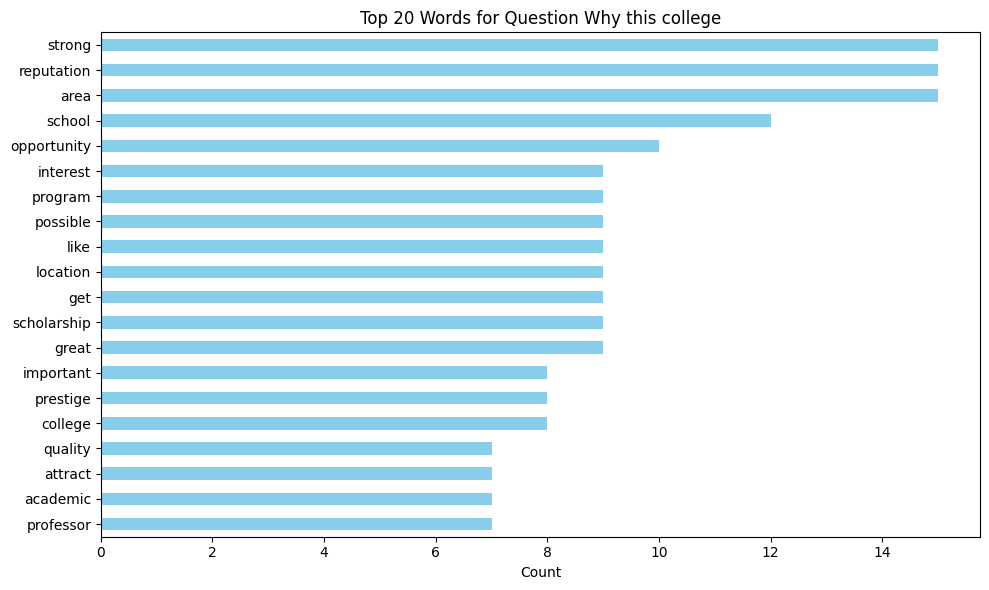

In [42]:
l.questions[3].visualize_answers_bar()

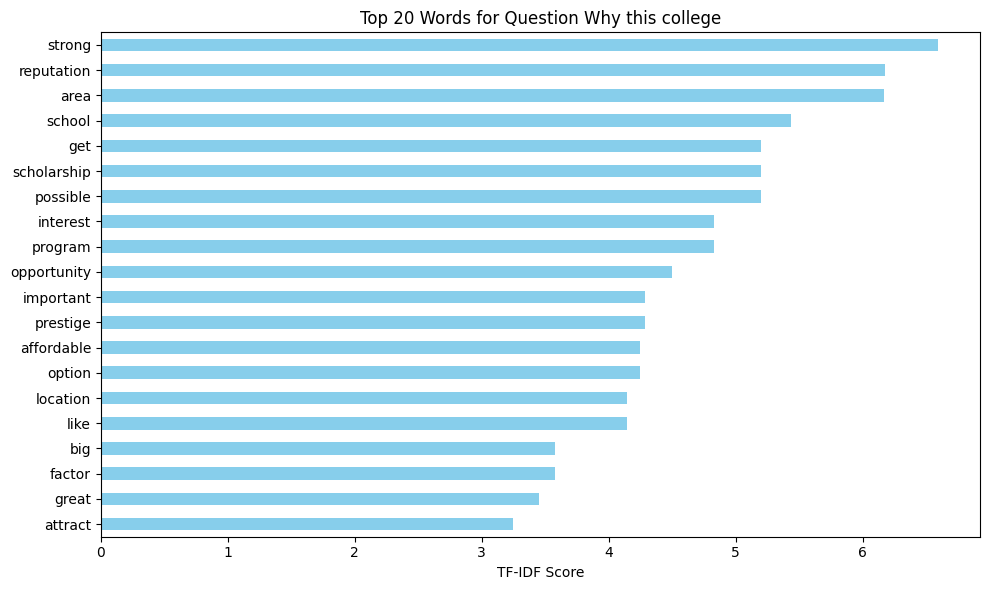

In [43]:
l.questions[3].visualize_answers_bar(use_tfidf=True)

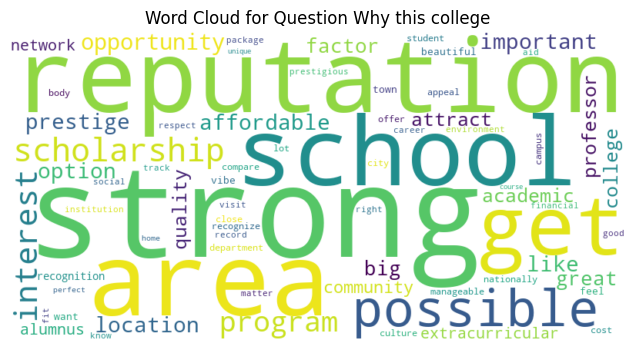

In [44]:
l.questions[3].visualize_answers_cloud(use_tfidf=True)

### Answer topic models

Finally, you can also get some topic models out of the answers by question.

In [45]:
l.questions[3].fit_answers_tm_lda(n_topics=5)

topic  num_docs  avg_prevalence  \
4      4        33        0.293236   
1      1        25        0.240196   
2      2        19        0.196624   
3      3        12        0.139956   
0      0        11        0.129987   

                                           top_words  \
4  [(important, 1.639990847477682), (prestige, 1....   
1  [(possible, 1.6727171723930725), (scholarship,...   
2  [(interest, 1.6727210335153355), (program, 1.6...   
3  [(campus, 1.4857093413021294), (body, 1.485709...   
0  [(network, 1.5499955670185281), (recognition, ...   

                                            top_docs  
4  [(80, 0.8662167743324205), (33, 0.866216774332...  
1  [(79, 0.8853397471478043), (75, 0.885339747147...  
2  [(88, 0.8664888651218425), (64, 0.866488865121...  
3  [(98, 0.8666637824014785), (96, 0.866663782401...  
0  [(97, 0.8658602952396491), (82, 0.865860295239...

In [46]:
l.questions[3].fit_answers_itm()

InteractiveTopicModel(fitted, docs=100, topics=4, assigned=100)

In [47]:
l.questions[3].answers_itm.visualize_documents()